In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import sklearn
import scipy

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
heart = pd.read_csv('FinalHeart.csv')
heart.drop(['Unnamed: 0'],axis=1,inplace=True)
heart.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0


In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
dtc = DecisionTreeClassifier()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = heart.drop(['num'],axis=1).copy()
Y = heart.num.copy()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.33, stratify=Y)

In [9]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [12]:
dtc = DecisionTreeClassifier()
dtc.set_params( random_state = 144)
%time dtc.fit(X_train, Y_train)
r2_train = np.round(dtc.score(X_train, Y_train),3)
r2_test  = np.round(dtc.score(X_test, Y_test),3)
print('Train score is :' + str(r2_train))
print('Test score is :' + str(r2_test))

CPU times: total: 0 ns
Wall time: 5.02 ms
Train score is :1.0
Test score is :0.508


In [13]:
heart.shape

(720, 14)

In [14]:
criterion      = ['gini','entropy','log_loss']
max_depth      = np.arange(1,80, 5)
max_features   = np.arange(1,14,2)
max_leaf_nodes = np.arange(1,40,5)
min_samples_leaf  = np.arange(1,50,5)
min_samples_split = np.arange(2,20,2)

In [16]:
dtc = DecisionTreeClassifier()
dtc.set_params( random_state = 144)

param_grid = {'criterion':criterion, 'max_depth':max_depth, 'max_features':max_features, 'max_leaf_nodes':max_leaf_nodes,
             'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split}
dtc_grid = GridSearchCV(dtc, param_grid, cv = 3, return_train_score=True)
%time dtc_grid.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
302400 fits failed out of a total of 725760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 314, in fit
    raise ValueError(
ValueError: max_leaf_nodes 1 must be either None or larger than 1

---

CPU times: total: 39min 54s
Wall time: 40min 9s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=144),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76]),
                         'max_features': array([ 1,  3,  5,  7,  9, 11, 13]),
                         'max_leaf_nodes': array([ 1,  6, 11, 16, 21, 26, 31, 36]),
                         'min_samples_leaf': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             return_train_score=True)

In [17]:
dtc_df = pd.DataFrame(dtc_grid.cv_results_)
dtc_df.shape

(241920, 22)

In [21]:
dtc_df.dropna(axis = 0, how = 'any', inplace=True)

In [22]:
dtc_df.shape

(141120, 22)

In [23]:
dtc_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_max_features',
       'param_max_leaf_nodes', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [24]:
dtc_final_df = dtc_df.loc[:,['param_criterion','param_max_depth','param_max_features',
                            'param_max_leaf_nodes','param_min_samples_leaf','param_min_samples_split',
                            'mean_train_score','mean_test_score']]

In [25]:
dtc_final_df.sample(10)

,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,mean_train_score,mean_test_score
42660,gini,41,7,11,1,2,0.710600,0.620367
92079,entropy,11,3,36,6,2,0.704337,0.603753
18492,gini,16,9,26,21,14,0.661829,0.641046
63999,gini,61,9,36,6,2,0.748963,0.591291
145316,entropy,61,11,31,31,6,0.654586,0.616253
32243,gini,31,5,31,11,12,0.690854,0.589195
107150,entropy,26,3,31,26,12,0.647295,0.609990
43611,gini,41,9,21,26,14,0.657679,0.649392
62262,gini,61,5,16,41,2,0.614117,0.591278
102693,entropy,21,5,26,1,8,0.735457,0.601695


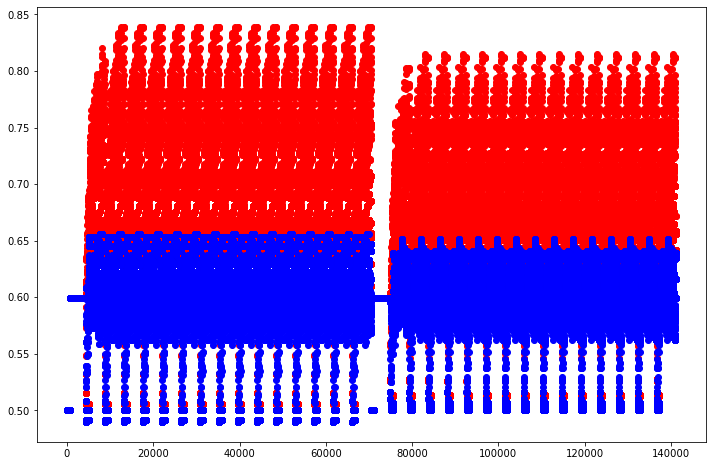

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

plt.scatter(x = np.arange(0,dtc_final_df.shape[0]), y = dtc_final_df.mean_train_score, color ='red')
plt.scatter(x = np.arange(0,dtc_final_df.shape[0]), y = dtc_final_df.mean_test_score, color ='blue');

In [30]:
dtc_final_df.to_csv('DecisionTreeCV.csv')